In [1]:
import tensorflow as tf
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [3]:
tf.reset_default_graph()

In [4]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
y = tf.placeholder(tf.int64, shape=(None), name='y')

In [5]:
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs + n_neurons)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name='kernel')
        b = tf.Variable(tf.zeros([n_neurons]), name='bias')
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

In [6]:
he_init = tf.contrib.layers.variance_scaling_initializer(factor=2., mode='FAN_AVG')


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [7]:
with tf.name_scope('dnn'):
    hidden1 = neuron_layer(X, n_hidden1, name='hidden1', activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name='hidden2', activation=tf.nn.relu)
    logits = neuron_layer(hidden2, n_outputs, name='outputs')
#     hidden1 = tf.layers.dense(X, n_hidden1, name='hidden1', activation=tf.nn.elu, kernel_initializer=he_init)
#     hidden2 = tf.layers.dense(hidden1, n_hidden2, name='hidden2', activation=tf.nn.elu, kernel_initializer=he_init)
#     logits = tf.layers.dense(hidden2, n_outputs, name='outputs')

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')

In [9]:
learning_rate = 0.01

with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [10]:
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [11]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [12]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/tmp/data')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [13]:
n_epochs = 40
batch_size = 50

In [14]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: mnist.validation.images, y: mnist.validation.labels})
        loss_val = loss.eval(feed_dict={X: X_batch, y: y_batch})
        print(epoch, 'Training accuracy:', acc_train, 'Val accuracy:', acc_val, 'loss:', loss_val)
        save_path = saver.save(sess, './my_model_final.ckpt')

0 Training accuracy: 0.94 Val accuracy: 0.9162 loss: 0.17085968
1 Training accuracy: 0.94 Val accuracy: 0.9336 loss: 0.2185854
2 Training accuracy: 0.96 Val accuracy: 0.942 loss: 0.21825561
3 Training accuracy: 0.94 Val accuracy: 0.9458 loss: 0.22399151
4 Training accuracy: 0.92 Val accuracy: 0.9554 loss: 0.21854389
5 Training accuracy: 0.94 Val accuracy: 0.956 loss: 0.34444275
6 Training accuracy: 1.0 Val accuracy: 0.9612 loss: 0.068191975
7 Training accuracy: 0.96 Val accuracy: 0.9628 loss: 0.18476403
8 Training accuracy: 1.0 Val accuracy: 0.9656 loss: 0.04855298
9 Training accuracy: 0.94 Val accuracy: 0.9662 loss: 0.19356573
10 Training accuracy: 0.98 Val accuracy: 0.9678 loss: 0.089037836
11 Training accuracy: 0.98 Val accuracy: 0.968 loss: 0.0614865
12 Training accuracy: 0.98 Val accuracy: 0.9704 loss: 0.0646231
13 Training accuracy: 0.98 Val accuracy: 0.9704 loss: 0.07755824
14 Training accuracy: 1.0 Val accuracy: 0.972 loss: 0.016833613
15 Training accuracy: 1.0 Val accuracy: 0.

In [15]:
with tf.Session() as sess:
    saver.restore(sess, './my_model_final.ckpt')
    X_new_scaled = mnist.test.images
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


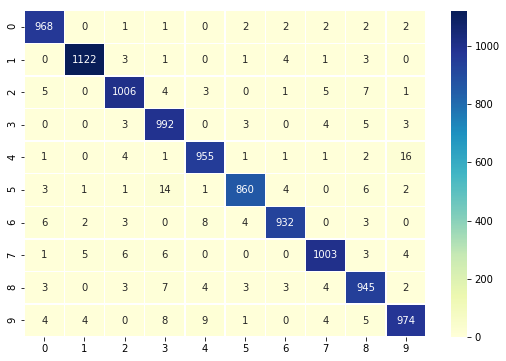

In [16]:
cf = (metrics.confusion_matrix(mnist.test.labels, y_pred=y_pred))
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(cf, annot=True, fmt="d", linewidths=.5, ax=ax, cmap='YlGnBu')

In [17]:
print(metrics.classification_report(mnist.test.labels,y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.96      0.98      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.98      0.96      0.97       892
           6       0.98      0.97      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.96      0.97      0.97       974
           9       0.97      0.97      0.97      1009

   micro avg       0.98      0.98      0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [18]:
with tf.Session() as sess:
    saver.restore(sess, './my_model_final.ckpt')
    acc_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
    print(acc_val)

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0.9757
